### Goals of this notebook:
#### Mostly used to build things that will find their way into .py files. 
1. Build object detection dataset and dataloader.
    - Visualize a labeled example
    - Print metrics for bounding-box labeled images.
2. Copy relevant numpy data into a new train and val split directories
    - Get path from the .csv
    - Copy bounding box labels over in a pytorch-friendly manner
3. Load PyTorch image detection model
    - Train on a smaller version of the dataset
    - Experiment with 2 different architectures in torchvision.detection
4. Train PyTorch model, get classification metrics
    - May not be very good, that's alright

In [26]:
import torch
import random
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import pickle as pkl
import glob

from tqdm.notebook import tqdm
sys.path.append("../")
import constants

### Goal 1a: Build object detection dataset and dataloader.

In [33]:
df = pd.read_csv("../dataset/BBox_List_2017.csv")
print("Num examples:", len(df))
df.head()

Num examples: 984


Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN

In [34]:
print(f"Disease counts:\n{df['Finding Label'].value_counts()}")
print()
df["area"] = np.array(df["w"]) * np.array(df["h]"])
print(df.groupby("Finding Label").area.median())

Disease counts:
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

Finding Label
Atelectasis      19665.951110
Cardiomegaly    179210.477073
Effusion         58400.408177
Infiltrate       59376.155391
Mass             15467.143269
Nodule            4800.065718
Pneumonia        59967.266224
Pneumothorax     37548.167696
Name: area, dtype: float64


In [57]:
def display_bbox_image(idx):
    path = df.iloc[idx]["Image Index"].split(".")[0] + ".npy"
    disease = df.iloc[idx]["Finding Label"]
    print(disease)
    x, y, w, h = df.iloc[idx, 2:6]
    
    np_dir = "../dataset/numpy_classification_data/"
    for d in ["train/", "test/", "val/"]:
        try:
            img = np.load(np_dir + d + path)
        except FileNotFoundError:
            pass
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    print(img.shape)
    rect=mpatches.Rectangle((x, y),h,w, 
                            fill = False,
                            color = "red",
                            linewidth = 4,
                            linestyle="-.")
    # plt.gca().add_patch(rect)
    plt.show()
    plt.savefig(f"imgs/{idx}.png", format="png")
    

Cardiomegaly
(1024, 1024)


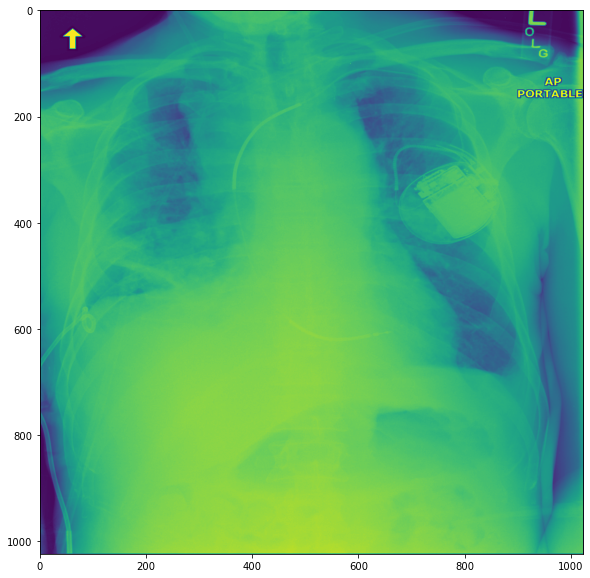

<Figure size 432x288 with 0 Axes>

In [58]:
display_bbox_image(200)

### Goal 2: Copy relevant images into new dataset.

In [41]:
bbox_path = "../dataset/numpy_bbox_data/"

def copy_relevant_data(df, idx, split="train"):
    
    # copy over image data
    path = df.iloc[idx]["Image Index"].split(".")[0] + ".npy"
    np_dir = "../dataset/numpy_classification_data/"
    
    for d in ["train/", "test/", "val/"]:
        try:
            img = np.load(np_dir + d + path)
        except FileNotFoundError:
            pass
    
    np.save(bbox_path + split + "/" + path, img)
    
    
    # create and copy over bounding box and label data
    # matching format here: 
    # https://pytorch.org/vision/main/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
    x, y, w, h = df.iloc[idx, 2:6]
    label = df.iloc[idx]["Finding Label"]
    label_idx = np.array([constants.LABELS_TO_IDXS[label]])
    
    x1 = x 
    x2 = x + w
    
    y1 = y 
    y2 = y + h
    
    corners = np.array([x1, y1, x2, y2])
    corners = np.expand_dims(corners, 0)
    
    d = {}
    d['boxes'] = torch.from_numpy(corners).float()
    d['labels'] = torch.from_numpy(label_idx).long()
    
    pkl.dump(d, open(bbox_path + split + "_labels" + "/" + path.split(".")[0] + ".pkl", "wb"))
    
    
    

In [42]:
df

Image Index Finding Label     Bbox [x           y           w  \
0    00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1    00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2    00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3    00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4    00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   
..                ...           ...         ...         ...         ...   
979  00029464_015.png   Atelectasis  198.940451  352.900747  615.537778   
980  00025769_001.png   Atelectasis  701.838229  572.491858  103.537778   
981  00016837_002.png   Atelectasis  140.913785  658.962969  271.928889   
982  00020124_003.png   Atelectasis  175.047118  580.456302  244.622222   
983  00026920_000.png   Atelectasis  343.438229  446.198524  120.604444   

             h]  Unnamed: 6  Unnamed: 7  Unnamed: 8           area  
0     79.186441         NaN         NaN         NaN    6871.772479  
1    313.491525         NaN         NaN         NaN   58150.021258  
2    216.949153         NaN         NaN         NaN   33652.858374  
3     55.322034         NaN         NaN         NaN    7801.344441  
4     78.101695         NaN         NaN         NaN   15673.289285  
..          ...         ...         ...         ...            ...  
979  323.128889         NaN         NaN         NaN  198898.038202  
980   63.715556         NaN         NaN         NaN    6596.967032  
981   94.435556         NaN         NaN         NaN   25679.755694  
982  103.537778         NaN         NaN         NaN   25327.641284  
983   53.475556         NaN         NaN         NaN    6449.389669  

[984 rows x 10 columns]

In [59]:
sample = df.sample(frac=.85, random_state=1)
sample_imgs = sample["Image Index"].tolist()

train_df = df[df["Image Index"].isin(sample_imgs)].copy()
val_df = df[~df["Image Index"].isin(sample_imgs)].copy()

train_df["split"] = "train"
val_df["split"] = "val"

print(train_df["Finding Label"].value_counts(normalize=True))
print(val_df["Finding Label"].value_counts(normalize=True))

final_df = pd.concat([train_df, val_df], axis=0)

Atelectasis     0.181609
Effusion        0.162069
Cardiomegaly    0.142529
Infiltrate      0.126437
Pneumonia       0.124138
Pneumothorax    0.093103
Mass            0.087356
Nodule          0.082759
Name: Finding Label, dtype: float64
Atelectasis     0.192982
Cardiomegaly    0.192982
Pneumothorax    0.149123
Infiltrate      0.114035
Effusion        0.105263
Pneumonia       0.105263
Mass            0.078947
Nodule          0.061404
Name: Finding Label, dtype: float64


In [60]:
dataset_splits = final_df["split"].tolist()
for idx, split in tqdm(zip(range(len(final_df)), dataset_splits)):
    copy_relevant_data(final_df, idx, split)

0it [00:00, ?it/s]

NameError: name 'copy_relevant_data' is not defined

### Goal 1b: Build a Dataloader

In [61]:
# Hey sam, you made a mistake, should not use these pre-process transforms if you can help it, want to maintain full size of the image. May need to rescale some things. 
def get_preprocess_transforms():
    """
    Returns a torchvision.transforms composition to apply.
    Note that mean/std were computed via the script within utils.py
    """

    preprocess_transforms = T.Compose([
        #T.Resize(256),
        T.Normalize(
            mean=[129.1120817169278],
            std=[64.12445895568287]
        )
    ])
    
    return preprocess_transforms

class CXR_Detection_Dataset(Dataset):
    """
    Multi-label classification task for chest x-ray dataset.
    """
    def __init__(self, mode='train'):
        self.transform = get_preprocess_transforms()
        if mode == 'train':
            self.data_path = constants.DETECTION_TRAIN_DIR
            self.label_path = constants.DETECTION_TRAIN_LABELS_DIR
        elif mode == 'val':
            self.data_path = constants.DETECTION_VAL_DIR
            self.label_path = constants.DETECTION_VAL_LABELS_DIR
        else:
            print(f'Error: mode should be one of [train, val, test] but got {mode} instead.')

        # --- Construct mapping from indices to examples ---
        self.data_filenames = sorted(list(glob.glob(os.path.join("../", self.data_path, '*'))))
        self.label_filenames = sorted(list(glob.glob(os.path.join("../", self.label_path, '*'))))
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def __getitem__(self, idx):
        
        # --- Load the numpy array and convert into a torch tensor ---
        x = torch.from_numpy(np.load(self.data_filenames[idx])).float().unsqueeze(0)
        # --- Some of the tensors have channels for some reason... ---
        if len(x.shape) == 4:
            x = x[:, :, :, 0]
        x = self.transform(x)
        with open(self.label_filenames[idx], "rb") as f: 
            y = pkl.load(f)

        return x, y

    def __len__(self):
        return len(self.data_filenames)

In [62]:
def evaluate(model, data_loader):
    
    with torch.no_grad():
        val_losses = []

        for images, dicts in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_losses.append(losses.item())

        print("Val loss:", np.mean(val_losses))
        return np.mean(val_losses)
    

def train_one_epoch(model, optimizer, train_loader, device, epoch, val_loader, lr_scheduler):
    model.train()
    print(f"Epoch [{epoch}]")
    epoch_loss = []
    for idx, (images, dicts) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        epoch_loss.append(losses.item())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    lr_scheduler.step(np.mean(epoch_loss))
    
    print(f"Train loss: {np.mean(epoch_loss)}")
    val_loss = evaluate(model, val_loader)
    iou = evaluate_iou(model, val_loader)
    
    return val_loss, iou
    
    
def calc_iou(pred, target, shape=(1024, 1024)):

    tx1, ty1, tx2, ty2 = target.cpu().numpy()[0]
    
    px1, py1, px2, py2 = pred.cpu().numpy()
    
    x_left = max(px1, tx1)
    y_top = max(py1, ty1)
    x_right = min(px2, tx2)
    y_bottom = min(py2, ty2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    p_area = (px2 - px1) * (py2 - py1)
    t_area = (tx2 - tx1) * (ty2 - ty1)

    iou = intersection_area / float(p_area + t_area - intersection_area)

    return iou
    
    
def evaluate_iou(model, dataloader, k=1):
    model.eval()
    iou_scores = []
    with torch.no_grad():
        for images, dicts in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]
            
            predictions = model(images)
            # print(predictions)
            for pred, target in zip(predictions, targets):
                target_box = target['boxes']
                pred_boxes, scores = pred['boxes'], pred['scores']
                
                if len(scores) > k:
                    idxs = torch.topk(scores, k).indices
                    pred_boxes = pred_boxes[idxs]
                
                for pred_box in pred_boxes:
                    iou_scores.append(calc_iou(pred_box, target_box))
                    
        print("Avg IOU score:", np.mean(iou_scores) if len(iou_scores) else "N/A, no bbox predictions.")
        return np.mean(iou_scores)

def set_random_seed(seed=88888888):
    """
    For consistency, set seeds for various packages here.
    -Random
    -Numpy
    -Torch
    """
    torch.backends.cudnn.deterministic=True
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print('Random seed set to {}'.format(seed))
    

In [201]:
evaluate_iou(model, val_loader, k=1)

[]
Avg IOU score: N/A, no bbox predictions.


In [67]:
# alright let's try to train it:
set_random_seed()  

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = num_classes=max(constants.get_indexes_to_weights()) + 1
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, 
                                                                       num_classes=num_classes,
                                                                       rpn_post_nms_top_n_test=10,
                                                                      )
model = model.to(device)

train_dset = CXR_Detection_Dataset()
val_dset = CXR_Detection_Dataset(mode="val")

train_loader = torch.utils.data.DataLoader(
        train_dset, batch_size=16, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=16, shuffle=False, num_workers=4)

lr = 1e-3
num_epochs = 50

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, cooldown=3, verbose=True, threshold=.01)

logdir = create_unique_logdir("faster_rcnn_mobilenet", lr)

max_iou = 0

for epoch in tqdm(range(num_epochs)):
    # train one epoch
    val_loss, iou = train_one_epoch(model, optimizer, train_loader, device, epoch, val_loader, lr_scheduler)
    # evaluate on val dataset
    if (epoch + 1) % 10 == 0:
        print(f"Saving epoch {epoch}.")
        save_checkpoint(logdir, model, optimizer, epoch, val_loss, lr)
        
    if epoch != 0 and not np.isnan(iou) and iou > max_iou:
        print(f"Saving best IOU.")
        max_iou = iou
        save_checkpoint(logdir, model, optimizer, epoch, val_loss, lr, "best_iou")

Random seed set to 88888888


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0]
Train loss: 0.7186335399746895
Val loss: 0.2781947273761034
Avg IOU score: N/A, no bbox predictions.
Epoch [1]
Train loss: 0.285218195587981
Val loss: 0.21429687645286322
Avg IOU score: N/A, no bbox predictions.
Epoch [2]
Train loss: 0.28698500464944277
Val loss: 0.25461326353251934
Avg IOU score: N/A, no bbox predictions.
Epoch [3]
Train loss: 0.2912943407016642
Val loss: 0.22481358610093594
Avg IOU score: N/A, no bbox predictions.
Epoch [4]
Train loss: 0.2938976290763593
Val loss: 0.2808762677013874
Avg IOU score: N/A, no bbox predictions.
Epoch [5]
Train loss: 0.2758778590782016
Val loss: 0.26983411237597466
Avg IOU score: N/A, no bbox predictions.
Epoch [6]
Train loss: 0.28475455092448815
Val loss: 0.28087401390075684
Avg IOU score: N/A, no bbox predictions.
Epoch [7]
Train loss: 0.300154236017489
Val loss: 0.36389628052711487
Avg IOU score: 0.17284847222437758
Saving best IOU.
Epoch [8]
Train loss: 0.30252859551532596
Val loss: 0.3246966879814863
Avg IOU score: 0.2321458

In [68]:
import time
def create_unique_logdir(logdir, lr, root_logdir="log/"):
    """
    Creates a unique log directory using the directory name and the time stamp
    Takes in a unqiue directory name and optionally a root directory path
    The root directory path is default to "log/" since all logs should be stored
    under that directory

    Example:
        > create_unique_logdir("baseline_lstm")
        "log/baseline_lstm_Y2020_M2_D27_h16_m5_lr3e-4"
    """
    if logdir == "":
        return logdir
    localtime = time.localtime(time.time())
    time_label = "Y{}_M{}_D{}_h{}_m{}_lr{}".format(localtime.tm_year, localtime.tm_mon, \
        localtime.tm_mday, localtime.tm_hour, localtime.tm_min, lr)
    unique_logdir = os.path.join(root_logdir, logdir + "_" + time_label)
    os.makedirs(unique_logdir, exist_ok=True)
    return unique_logdir

def save_checkpoint(logdir, model, optimizer, epoch, loss, lr, best=None):
    """
    Saves model checkpoint after each epoch

    best: An optional string used to specify which validation method this best
    checkpoint is for
    """
    checkpoint_dir = os.path.join(logdir, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    if best:
        checkpoint_path = "{}/best_{}.pth".format(checkpoint_dir, best)
    else:
        checkpoint_path = "{}/lr{}_epoch{}.pth".format(checkpoint_dir, lr, epoch)

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)

    if not best:
        print("Saving checkpoint to lr{}_epoch{}".format(lr, epoch))
        



In [69]:
def load_checkpoint(model_checkpoint, model, device, optimizer=None):
    """
    Loads a pretrained checkpoint to continue training
    model_checkpoint: Path of the model_checkpoint that ends with .pth
    """
    checkpoint = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model

Model drew 4 bounding boxes.
Model drew 9 bounding boxes.
Model drew 7 bounding boxes.
Model drew 5 bounding boxes.
Model drew 0 bounding boxes.
Model drew 1 bounding boxes.
Model drew 12 bounding boxes.
Model drew 5 bounding boxes.
Model drew 7 bounding boxes.
Model drew 6 bounding boxes.
Model drew 5 bounding boxes.
Model drew 8 bounding boxes.
Model drew 5 bounding boxes.


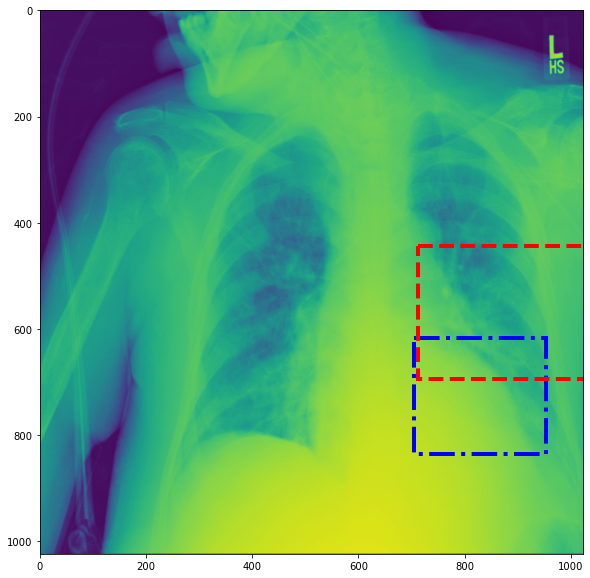

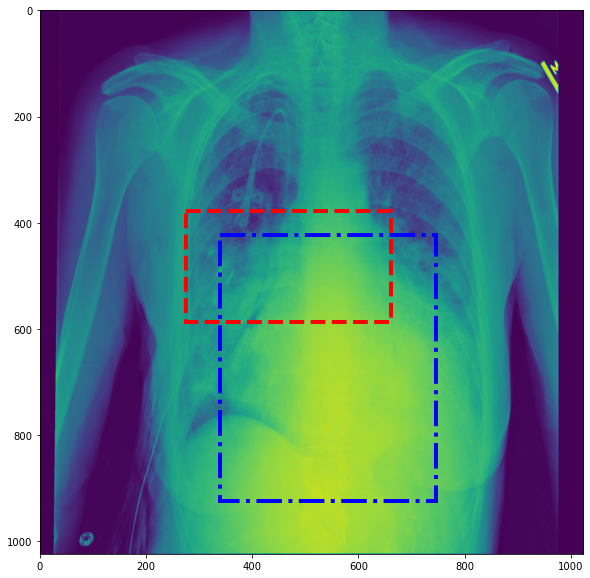

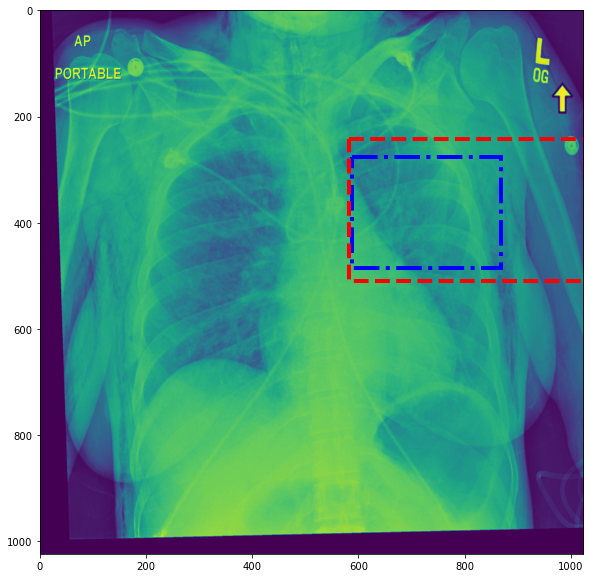

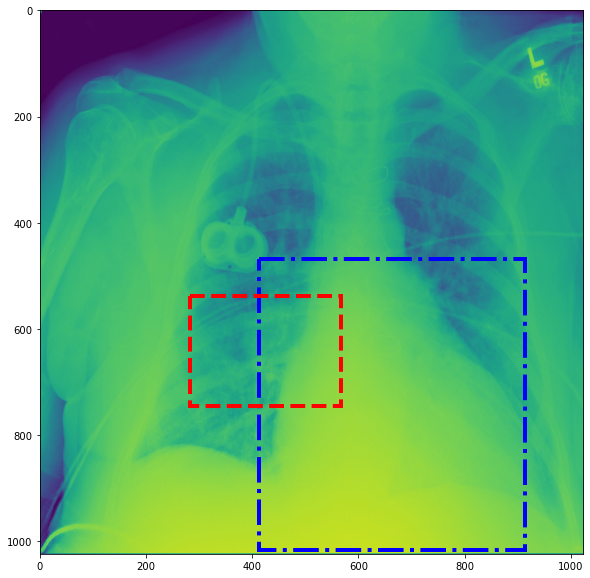

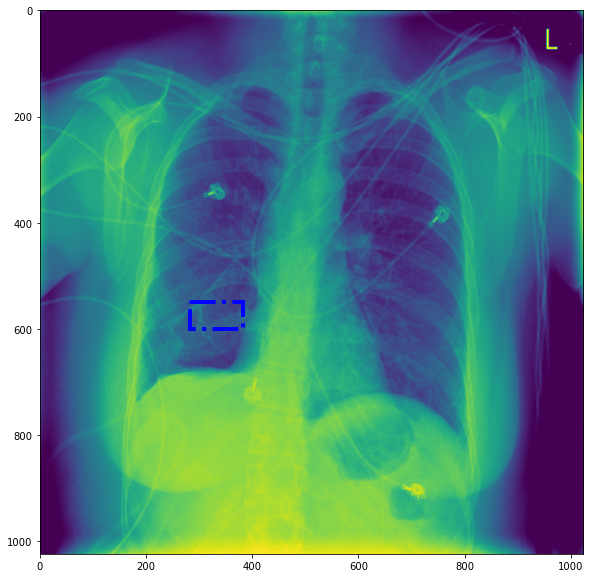

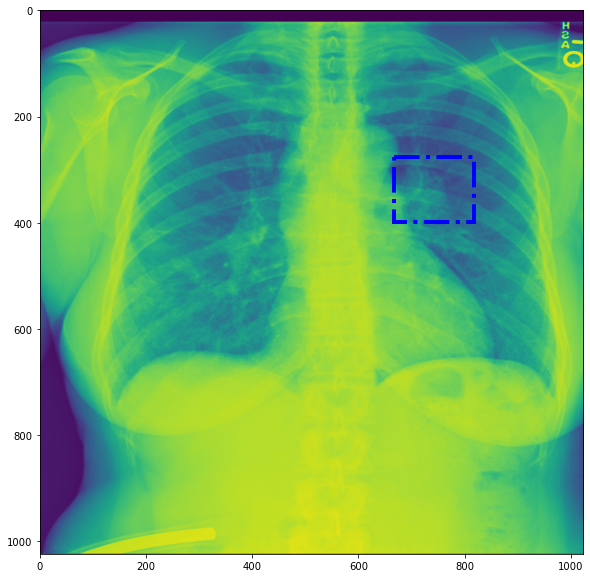

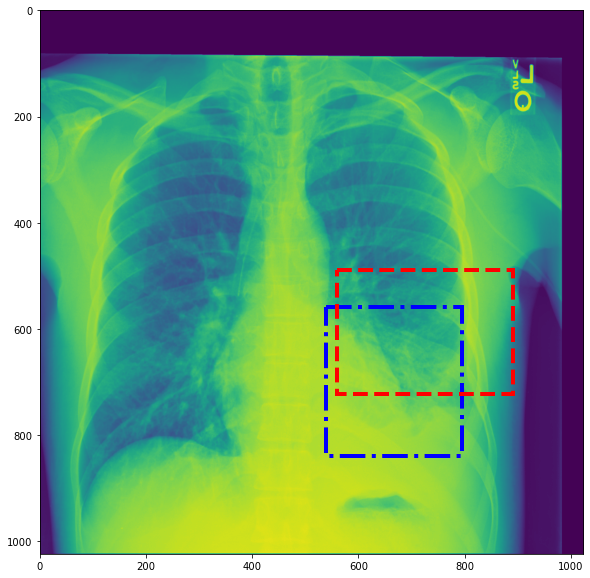

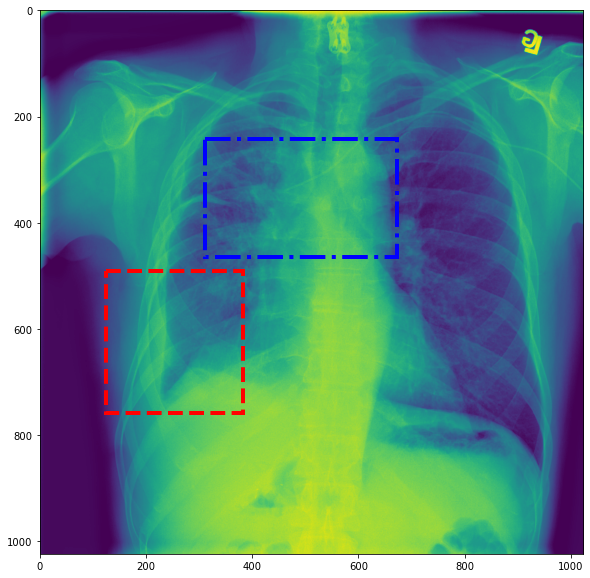

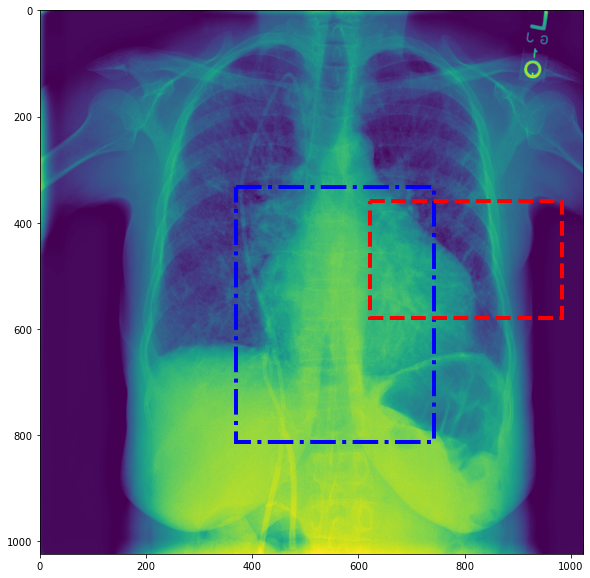

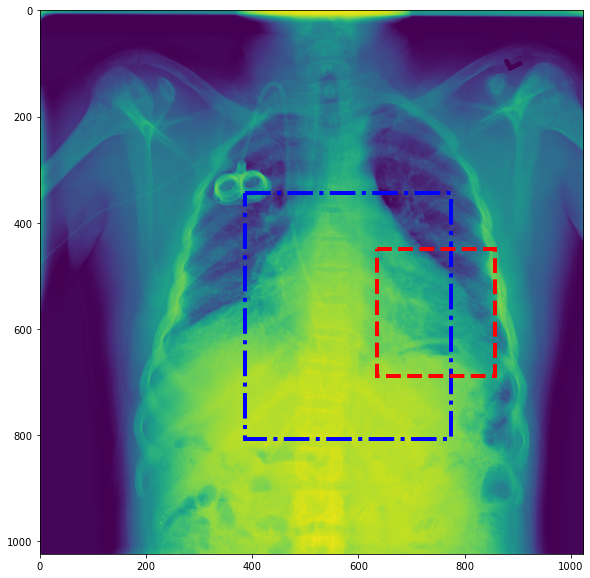

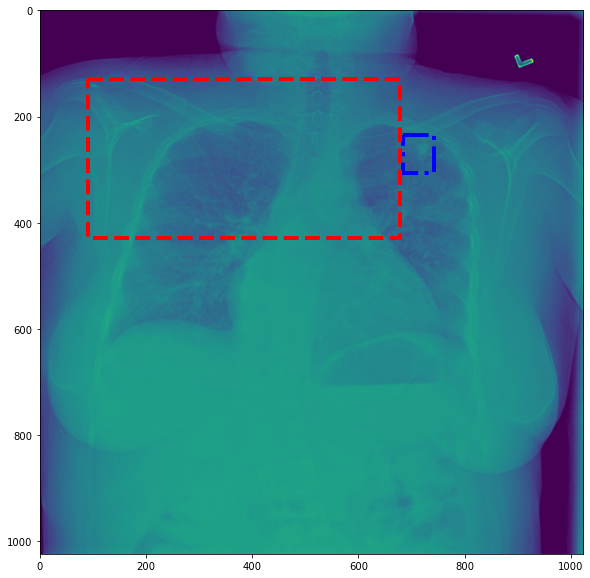

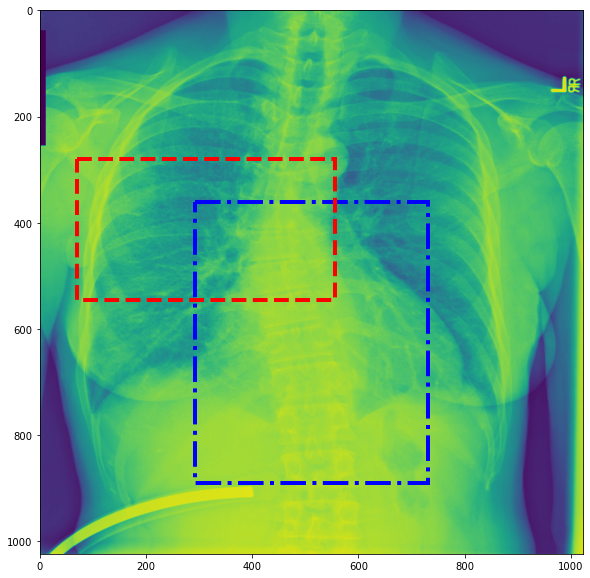

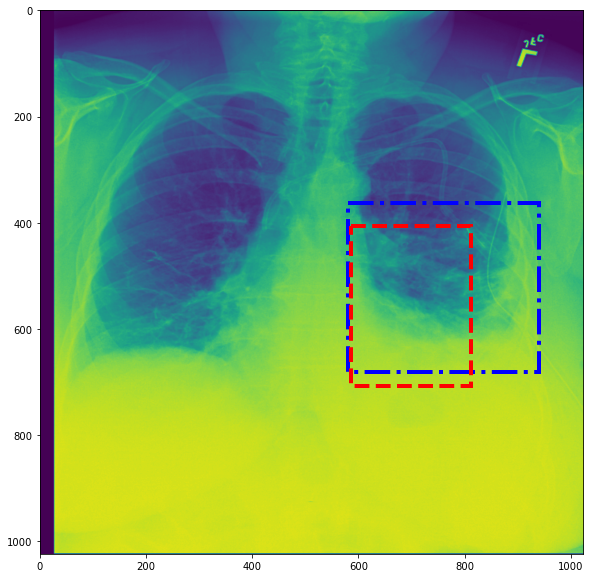

In [71]:
# let's look at the outputs! 

ONE_BOX = True
model.rpn._post_nms_top_n['testing'] = 1000

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=1, shuffle=False, num_workers=4)

# model = 

model.eval()
count = 0
with torch.no_grad():
    for images, dicts in val_loader:
        images = list(image.to(device) for image in images)
        targets = [{"boxes" : box.to(device), "labels" : label.to(device).long()} for box, label in zip(dicts["boxes"], dicts["labels"])]

        predictions = model(images)
        print(f"Model drew {len(predictions[0]['boxes'])} bounding boxes.")

        img = np.moveaxis(images[0].cpu().numpy(), 0, -1)
        plt.figure(figsize=(10,10))
        plt.imshow(img)

        # show actual prediction
        d = targets[0]
        x1, y1, x2, y2 = d['boxes'].cpu().numpy()[0]

        rect=mpatches.Rectangle((x1, y1),y2-y1,x2-x1, 
                                fill = False,
                                color = "blue",
                                linewidth = 4,
                                linestyle="-.")


        plt.gca().add_patch(rect)

        # print(d['labels'])

        pred = predictions[0]
        
        boxes = pred['boxes']
        scores = pred['scores']
        
        if len(scores) <= 1:
            continue
         
        if ONE_BOX:
            idxs = torch.topk(scores, 1).indices
            boxes = boxes[idxs]
            

        for coords in boxes:
            
            x1, y1, x2, y2 = coords.cpu().numpy()
            rect=mpatches.Rectangle((x1, y1),y2-y1,x2-x1, 
                                fill = False,
                                color = "red",
                                linewidth = 4,
                                linestyle="--")


            plt.gca().add_patch(rect)
            
        count += 1

        if count > 10:
            break

In [13]:
# next steps: save the model, maybe train another

# create dataset from teacher labels

# new dataloader to train on both

# train another model, compare scores to val

# badda boom badda bing baby

Model drew 1 bounding boxes.
tensor([11], device='cuda:0')
698.0452 296.22592 938.41034 771.4139
Model drew 9 bounding boxes.
tensor([0], device='cuda:0')
275.0474 304.7494 493.1827 733.4613
Model drew 1 bounding boxes.
tensor([5], device='cuda:0')
224.46257 295.72482 881.3403 821.81537
Model drew 2 bounding boxes.
tensor([0], device='cuda:0')
686.2849 392.1229 938.9085 840.8413
Model drew 0 bounding boxes.
tensor([8], device='cuda:0')
281.73544 548.30054 332.66455 649.07513
Model drew 10 bounding boxes.
tensor([7], device='cuda:0')
487.72656 397.31213 954.798 743.5725
Model drew 3 bounding boxes.
tensor([11], device='cuda:0')
464.66248 239.8965 820.36285 891.524
Model drew 0 bounding boxes.
tensor([11], device='cuda:0')
310.99258 242.72592 532.0466 603.564
Model drew 0 bounding boxes.
tensor([0], device='cuda:0')
368.42328 332.66455 848.45715 706.5058
Model drew 2 bounding boxes.
tensor([0], device='cuda:0')
299.27664 436.20627 426.48734 658.7657
Model drew 3 bounding boxes.
tensor([6

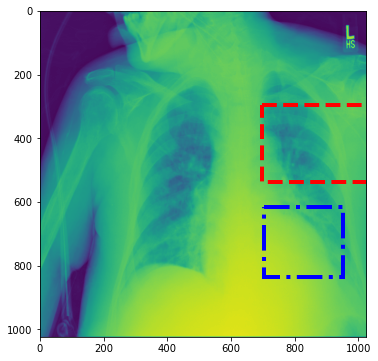

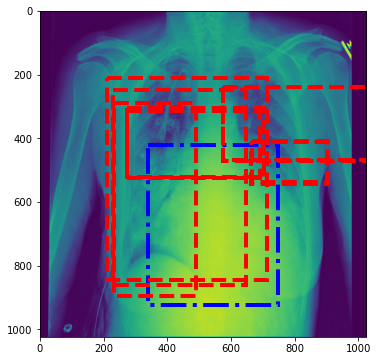

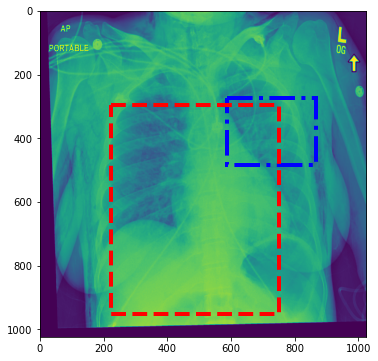

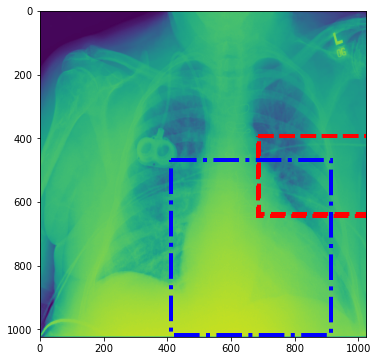

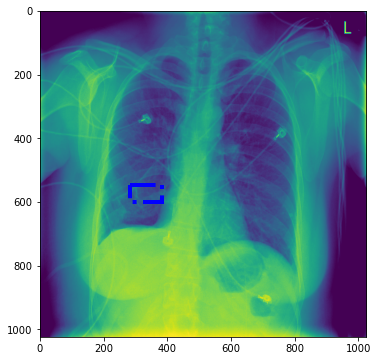

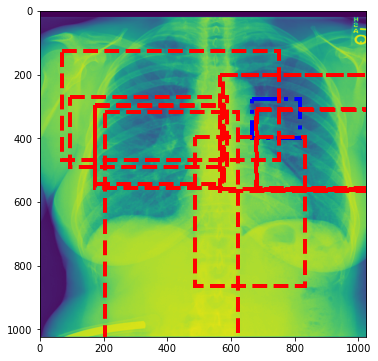

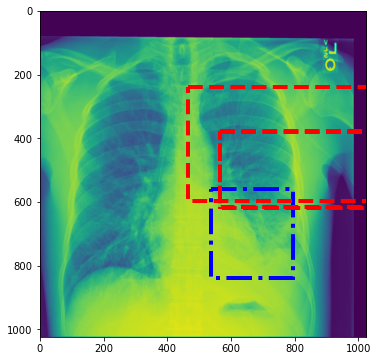

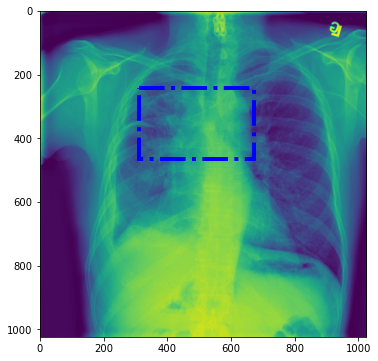

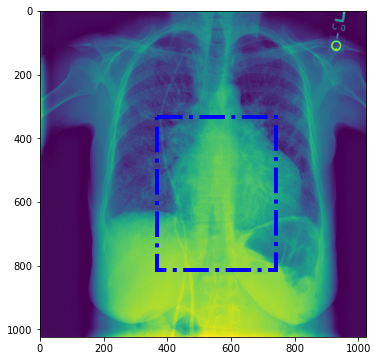

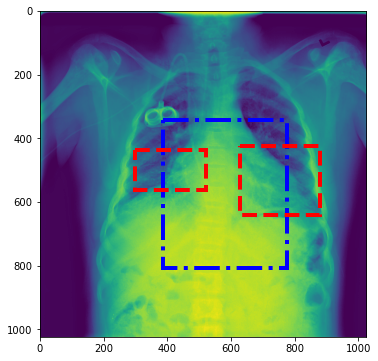

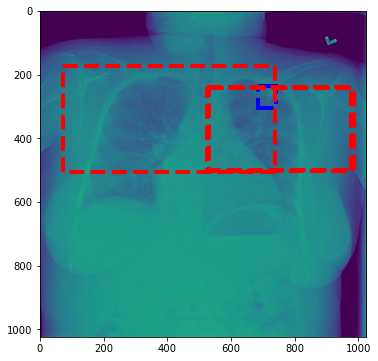